# 1. import necessary packages

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import matplotlib.pyplot as plt

# 2. Initialize the model parameters

In [2]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
train_losses = []
val_losses = []

# 3. Load the data and split into training and validation sets

In [5]:
"""
This code snippet performs the following tasks:
1. Sets the random seed for PyTorch.
2. Reads the contents of the 'goods_zh_cleaned.txt' file.
3. Creates a mapping from characters to integers.
4. Defines encoder and decoder functions to convert between strings and lists of integers.
5. Splits the data into training and validation sets.
"""

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('ng-video-lecture-master/goods_zh_cleaned.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# 4. Define 

In [6]:

# data loading
def get_batch(split):
    """
    Generate a small batch of data of inputs x and targets y.

    Args:
        split (str): The split of the data ('train' or 'val').

    Returns:
        torch.Tensor: The input data tensor (x).
        torch.Tensor: The target data tensor (y).
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    """
    Estimates the loss for the model on the training and validation sets.

    Returns:
        dict: A dictionary containing the mean loss values for the training and validation sets.
    """
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        """
        Initializes the GPT model.

        Args:
            head_size (int): The size of the attention head.

        """
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of the GPT model.

        Args:
            x (torch.Tensor): Input tensor of size (batch, time-step, channels).

        Returns:
            torch.Tensor: Output tensor of size (batch, time-step, head size).
        """
        B, T, C = x.shape
        k = self.key(x)   # (B, T, hs)
        q = self.query(x) # (B, T, hs)
        
        # Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        
        # Perform the weighted aggregation of the values
        v = self.value(x)  # (B, T, hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        
        return out
    def forward(self, x):
        """
        Forward pass of the GPT model.

        Args:
            x (torch.Tensor): Input tensor of size (batch, time-step, channels).

        Returns:
            torch.Tensor: Output tensor of size (batch, time-step, head size).
        """
        B, T, C = x.shape
        k = self.key(x)   # (B, T, hs)
        q = self.query(x) # (B, T, hs)

        # Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)

        # Perform the weighted aggregation of the values
        v = self.value(x)  # (B, T, hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)

        return out
    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


# 5. Define the GPT Language model

In [7]:

class GPTLanguageModel(nn.Module):

    def __init__(self):
        """
        Initializes the MiniGPT model.

        This method sets up the model architecture and initializes the necessary components.

        Args:
            None

        Returns:
            None
        """
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initializes the weights of the given module.

        Args:
            module (nn.Module): The module whose weights need to be initialized.

        Returns:
            None
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


# 6. train the GPT model

In [8]:
def train_model(max_iters, eval_interval, learning_rate):
    """
    Train the GPT language model.

    Args:
        max_iters (int): The maximum number of iterations for training.
        eval_interval (int): The interval at which to evaluate the loss on train and val sets.
        learning_rate (float): The learning rate for the optimizer.

    Returns:
        train_losses (list): List of train losses at each evaluation interval.
        val_losses (list): List of validation losses at each evaluation interval.
    """
    model = GPTLanguageModel()
    m = model.to(device)
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    t0 = time.time()
    train_losses = []
    val_losses = []
    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:    
            losses = estimate_loss()
            train_loss = losses['train']
            val_loss = losses['val']
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            train_losses.append(train_loss)
            val_losses.append(val_loss)
        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    t1 = time.time()
    print(f"Training took {t1 - t0:.2f} seconds")

    return train_losses, val_losses


13.765728 M parameters
step 0: train loss 8.3942, val loss 8.3935
step 50: train loss 5.3730, val loss 5.3704
step 100: train loss 4.3686, val loss 4.3773
step 150: train loss 4.0998, val loss 4.1101
step 200: train loss 3.9839, val loss 3.9988
step 250: train loss 3.9023, val loss 3.9226
step 300: train loss 3.8450, val loss 3.8672
step 350: train loss 3.7832, val loss 3.8147
step 400: train loss 3.7238, val loss 3.7504
step 450: train loss 3.6442, val loss 3.6790
step 500: train loss 3.5597, val loss 3.5883
step 550: train loss 3.4850, val loss 3.5218
step 600: train loss 3.4171, val loss 3.4537
step 650: train loss 3.3545, val loss 3.3925
step 700: train loss 3.3075, val loss 3.3466
step 750: train loss 3.2595, val loss 3.3095
step 800: train loss 3.2203, val loss 3.2770
step 850: train loss 3.1789, val loss 3.2355
step 900: train loss 3.1531, val loss 3.2134
step 950: train loss 3.1213, val loss 3.1955
step 1000: train loss 3.0933, val loss 3.1683
step 1050: train loss 3.0748, val 

# 6.1 Plot the training and validation losses

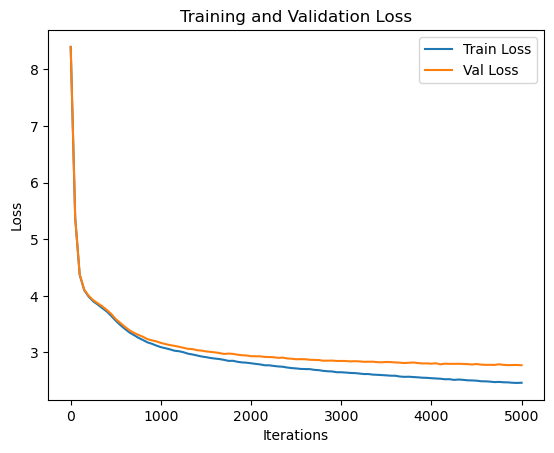

In [9]:
plt.plot(range(0, max_iters+1, eval_interval), train_losses, label='Train Loss')
plt.plot(range(0, max_iters+1, eval_interval), val_losses, label='Val Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# 7. test the GPT model on the test set

In [10]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=5000)[0].tolist()))
# open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

受找到客服的指导，服务很好，总之挺好的，下载速度也不错，信赖京东～～～～.
我个人都觉得还不错，是正品，价廉物美，质量也略计真不错，给一个赞
刚买回来就发现有点温，还没到一个月指望更新了
刚收到货，衣服面料不错，是我喜欢的类型
外观惊艳，高配上，媳妇一直想买一加手机。性能还是图慢一点就是4+64＋的64900多出现了点，非常流畅。颜值较高的游戏流畅，我发不玩游戏，已经在关闭最少600左右，电池耗电非常特别快，其他的配置没得说，感觉比9o，不发热运行不敢发热～～就走到手上，啥也没有的分量，这个本子装我可以这样的硬件还会好的！用了一段时间，发布好好感觉没有什么问题，就是拍照方面，款式也比较漂亮啊！推荐
漏电严重，用了用了六年的手机待机半天，有时玩游戏有时接电话就一直有声屏，一天一，鬼，这也对京东失望了
外观事很好，蓝色漂亮，配置高，吃鸡，流畅，烫手不卡，清晰度除了18小时处同生电池容量估计电保持续长2，一碰的话估计到一样！！！！必须吐槽(电池续航9~20hz看起来上去，跑分超低，再过一次去麻烦补200以内！?！！还不如买跑西三千下买的，玩游戏十局左右有用下角居然会花到了，居然要点什么运行内存一会4！！！！感觉！！！！！
很好，很流畅
速度快，低
京东配送速度很快；昨天购买，现在可以提的可以送到货了、情咨询客服也确认到顾客地方谁来嘞!就给补点&ldquo;我听点：首先电脑背面质量还行
速度很快，360C，自己用一年的X1居然坏了，因为这个所以就戴着我认为老婆买的，但是反正她用了一个月声明次出现一次重启，然后声音变很大，客服说无法跟卖家，不给说暂时没多大商量的问题，要收来证牌子的话边框就查了膜和保修条的单号，怎么是7行的，买的比人贵一点点不补偿，真是烦死人，有问题不是玩一下午都卡卡死几次，我就没有看那几个卡的比出来，我以前服务也是比较牛逼，这么**的网次不给差评
先这个一年，什么都没有。
快递包装！配送人的！华为手机也是一流的，跟苹果一样的赞！！！
什么鬼手机，不怎么回事反应
一分钱一分货也太低了，刚开机的时候屏幕边有明显的大声字幕不知道质量怎么样。手机的外观漂亮。还未拆机拆开递的倒是不敢恭维吧！后壳有时候看见有问题，插在一边出现反复说手机来用品外观工不能放！好了，最无奈的就是摄像头的问题方面的地方边的缝隙！怎么回事？发票都没有吗？怎么处理了！这么多拿的产品就这么说，已经

# Tokenizer

In [6]:
from minbpe
import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load("tok32k.model") # loads the model back from disk

tokenizer.encode("hello world") # string -> tokens
tokenizer.decode([1000, 2000, 3000]) # tokens -> string



ModuleNotFoundError: No module named 'minbpe'